## Training VGG16 Model - Full Face

In [16]:
import os
import shutil

# Define paths to your datasets
train_dir = '/Users/julia/Documents/project_code/train'
val_dir = '/Users/julia/Documents/project_code/val'
partial_faces_dir = '/Users/julia/Documents/project_code/partial_faces'

# Directory where extra classes will be moved
excluded_dir = '/Users/julia/Documents/project_code/excluded_classes'
os.makedirs(excluded_dir, exist_ok=True)

# Move classes not in validation to excluded directory
def sync_classes_with_validation(train_dir, val_dir, excluded_dir):
    train_classes = set(os.listdir(train_dir))
    val_classes = set(os.listdir(val_dir))

    # Classes that are in train but not in validation
    extra_train_classes = train_classes - val_classes

    if extra_train_classes:
        for class_name in extra_train_classes:
            src = os.path.join(train_dir, class_name)
            dst = os.path.join(excluded_dir, class_name)

            if os.path.exists(src) and not os.path.exists(dst):
                try:
                    shutil.move(src, dst)
                    print(f"Moved extra class '{class_name}' from train directory to '{excluded_dir}'.")
                except Exception as e:
                    print(f"Error moving class '{class_name}': {e}")
    else:
        print("All train classes are synced with validation.")

# Sync the classes between train and validation
sync_classes_with_validation(train_dir, val_dir, excluded_dir)

# Ensure partial_faces has the same classes as val
def sync_partial_faces_with_val(val_dir, partial_faces_dir):
    val_classes = set(os.listdir(val_dir))
    partial_classes = set(os.listdir(partial_faces_dir))

    extra_partial_classes = partial_classes - val_classes
    if extra_partial_classes:
        for class_name in extra_partial_classes:
            class_path = os.path.join(partial_faces_dir, class_name)
            shutil.rmtree(class_path)  # Remove extra classes from partial_faces
            print(f"Removed extra class '{class_name}' from partial_faces.")

    missing_partial_classes = val_classes - partial_classes
    if missing_partial_classes:
        for class_name in missing_partial_classes:
            class_path = os.path.join(partial_faces_dir, class_name)
            os.makedirs(class_path, exist_ok=True)
            
            # Copy a sample image from val to partial_faces to act as a dummy
            val_class_path = os.path.join(val_dir, class_name)
            images = os.listdir(val_class_path)
            if images:  # Only proceed if there are images in the class
                sample_image = images[0]  # Copy the first image from the class
                shutil.copy(os.path.join(val_class_path, sample_image), os.path.join(class_path, sample_image))
                print(f"Added dummy class '{class_name}' to partial_faces with image '{sample_image}'.")
            else:
                print(f"Class '{class_name}' in val has no images, skipping.")

# Sync the partial_faces dataset with the val dataset
sync_partial_faces_with_val(val_dir, partial_faces_dir)


All train classes are synced with validation.


In [17]:
# Import necessary libraries
from keras_vggface.vggface import VGGFace
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_vggface.utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

# Load the pre-trained VGGFace model (VGG16 variant)
base_model = VGGFace(include_top=False, model='vgg16', input_shape=(224, 224, 3))

# Set up data augmentation and preprocessing for full faces
full_faces_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255,
                                        rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

# Define directories for full faces dataset and validation set
full_faces_dir = '/Users/julia/Documents/project_code/train'
val_dir = '/Users/julia/Documents/project_code/val'

# Load full face dataset
full_faces_generator = full_faces_datagen.flow_from_directory(full_faces_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# Define the number of classes based on the full faces generator
NO_CLASSES = len(full_faces_generator.class_indices)  # This will give the number of classes

# Adding extra layers for our specific task
main_model = base_model.output
main_model = GlobalAveragePooling2D()(main_model)
main_model = Dense(1024, activation='relu')(main_model)
main_model = Dropout(0.5)(main_model)
main_model = Dense(512, activation='relu')(main_model)
preds = Dense(NO_CLASSES, activation='softmax')(main_model)

# Creating the final model
model = Model(inputs=base_model.input, outputs=preds)

# Freeze the initial layers
for layer in base_model.layers[:19]:
    layer.trainable = False

# Compile the model with Adam optimizer
optim = Adam(learning_rate=0.0001)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpointer = ModelCheckpoint(filepath='vgg16_finetuned_model.h5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model on full faces
history_full_faces = model.fit(
    full_faces_generator,
    validation_data=val_generator,
    epochs=100,  # Adjust the number of epochs based on your training time
    callbacks=[checkpointer, early_stop],
    verbose=1
)


# Set up data augmentation and preprocessing for partial faces
partial_faces_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

# Define directory for partial faces dataset
partial_faces_dir = '/Users/julia/Documents/project_code/partial_faces'

# Load partial face dataset
partial_faces_generator = partial_faces_datagen.flow_from_directory(partial_faces_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# Fine-tune the model on partial faces
history_partial_faces = model.fit(
    partial_faces_generator,
    validation_data=val_generator,
    epochs=100,  # Adjust the number of epochs based on your training time
    callbacks=[checkpointer, early_stop],
    verbose=1
)

# Save the model and weights after training
model.save('vgg16_finetuned_face_model.h5')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


# After training the model, save history object
with open('history_full_faces.pkl', 'wb') as f:
    pickle.dump(history_full_faces.history, f)



Found 4392 images belonging to 612 classes.
Found 1110 images belonging to 612 classes.
Epoch 1/100
138/138 [==============================] - 216s 2s/step - loss: 6.3574 - accuracy: 0.0674 - val_loss: 5.8812 - val_accuracy: 0.0712

Epoch 00001: val_loss improved from inf to 5.88115, saving model to vgg16_finetuned_model.h5
Epoch 2/100
138/138 [==============================] - 221s 2s/step - loss: 5.6175 - accuracy: 0.0884 - val_loss: 5.7254 - val_accuracy: 0.0991

Epoch 00002: val_loss improved from 5.88115 to 5.72536, saving model to vgg16_finetuned_model.h5
Epoch 3/100
138/138 [==============================] - 226s 2s/step - loss: 5.4656 - accuracy: 0.1122 - val_loss: 5.5887 - val_accuracy: 0.1036

Epoch 00003: val_loss improved from 5.72536 to 5.58874, saving model to vgg16_finetuned_model.h5
Epoch 4/100
138/138 [==============================] - 231s 2s/step - loss: 5.3195 - accuracy: 0.1202 - val_loss: 5.4636 - val_accuracy: 0.1036

Epoch 00004: val_loss improved from 5.58874 t

NameError: name 'history' is not defined

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# Test data generator (no data augmentation, just rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

test_dir = '/Users/julia/Documents/project_code/test'   

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False  # Disable shuffling to keep order of predictions and true labels aligned
)


ImportError: cannot import name 'layer_utils' from 'keras.utils' (/opt/anaconda3/envs/vgg_env/lib/python3.8/site-packages/keras/utils/__init__.py)

In [12]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('vgg16_finetuned_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


41/41 [==============================] - 27s 643ms/step - loss: 5.8037 - accuracy: 0.0874
Test Accuracy: 8.74%


In [13]:
# Evaluate the model on full faces
full_test_loss, full_test_accuracy = model.evaluate(full_faces_generator)
print(f"Full Faces Test Accuracy: {full_test_accuracy * 100:.2f}%")

# Evaluate the model on partial faces
partial_test_loss, partial_test_accuracy = model.evaluate(partial_faces_generator)
print(f"Partial Faces Test Accuracy: {partial_test_accuracy * 100:.2f}%")


138/138 [==============================] - 183s 1s/step - loss: 5.4773 - accuracy: 0.1166
Full Faces Test Accuracy: 11.66%
20/20 [==============================] - 13s 633ms/step - loss: 6.8012 - accuracy: 0.0033
Partial Faces Test Accuracy: 0.33%


In [15]:
import matplotlib.pyplot as plt

# Load history object from the saved file
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'history.pkl'

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_partial.history['accuracy'])
plt.plot(history_partial.history['val_accuracy'])
plt.title('Model Accuracy on Full and Partial Faces')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (Full Faces)', 'Validation (Full Faces)', 'Train (Partial Faces)', 'Validation (Partial Faces)'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_partial.history['loss'])
plt.plot(history_partial.history['val_loss'])
plt.title('Model Loss on Full and Partial Faces')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (Full Faces)', 'Validation (Full Faces)', 'Train (Partial Faces)', 'Validation (Partial Faces)'], loc='upper left')
plt.show()


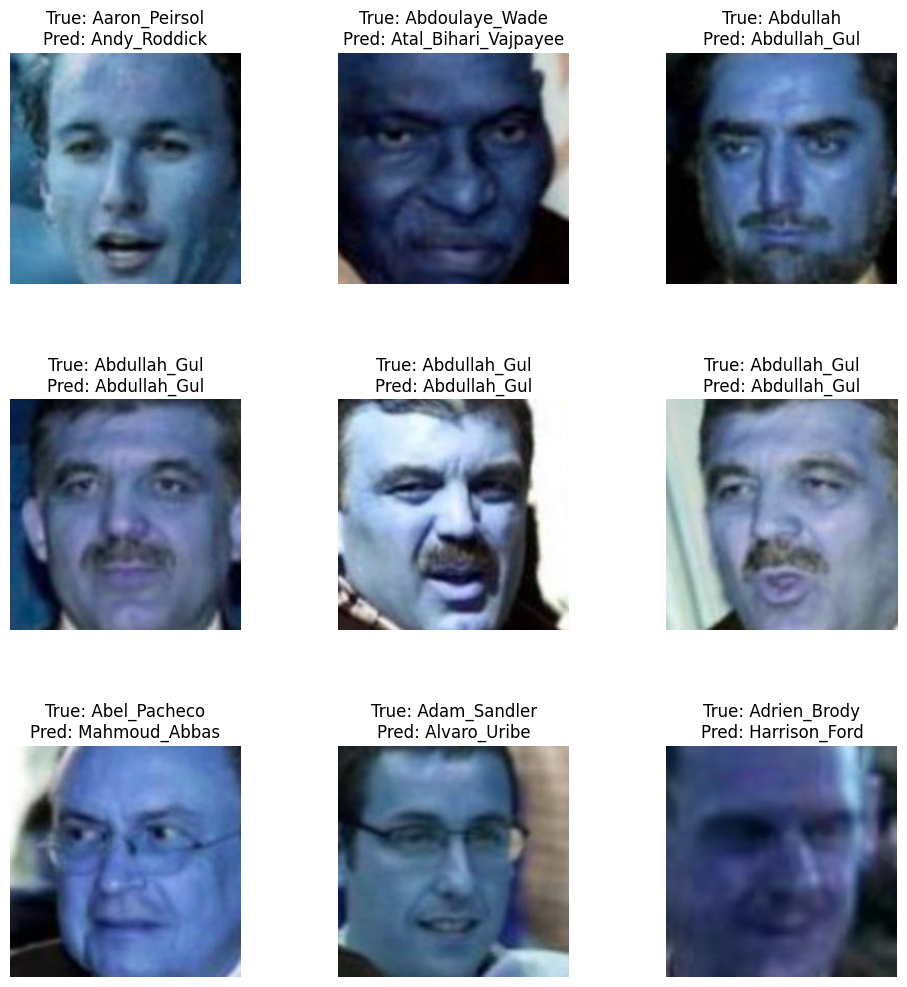

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Generate predictions for the test set
test_generator.reset()  # Reset the generator for correct indexing
preds = model.predict(test_generator)

# Get the predicted class labels
predicted_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Display a few predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 9):
    img_path, true_label_index = test_generator.filepaths[i], true_classes[i]
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image
    img = np.array(img)
    true_label = class_labels[true_label_index]
    predicted_label = class_labels[predicted_classes[i]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()


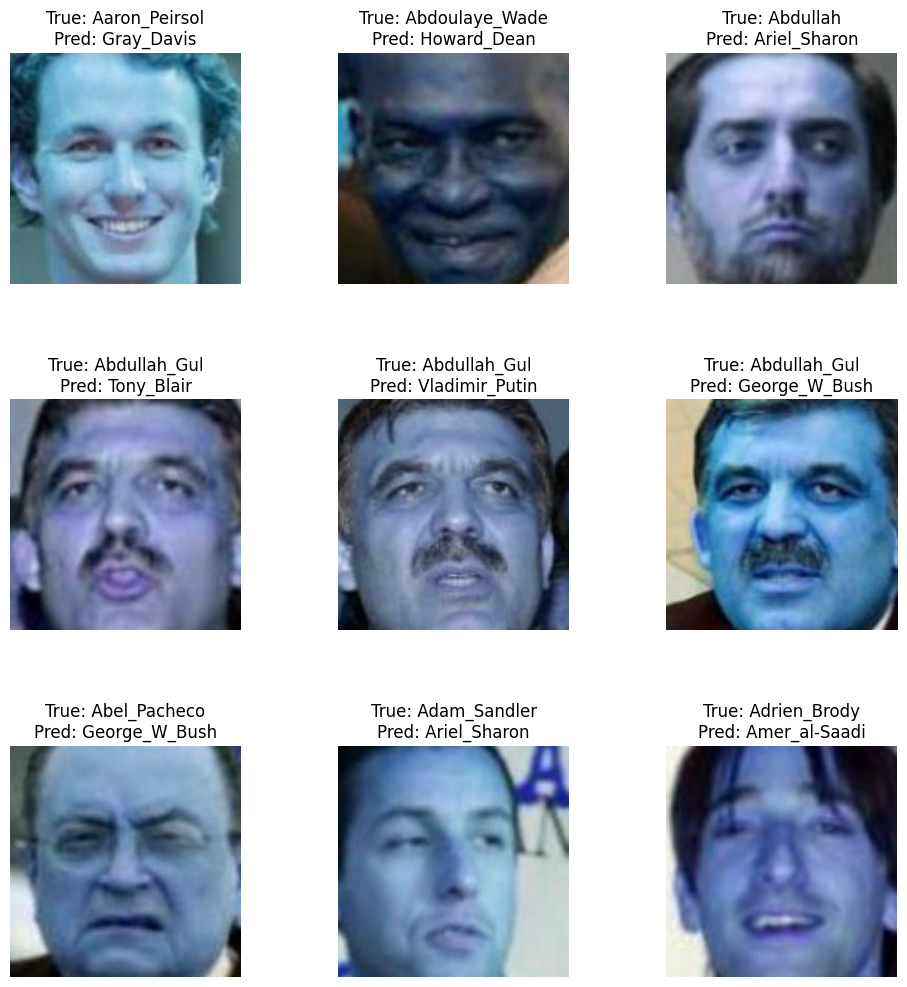

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Generate predictions for the validation set
val_generator.reset()
preds = model.predict(val_generator)

# Get the predicted class labels
predicted_classes = np.argmax(preds, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Display a few predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 9):
    img_path, true_label_index = val_generator.filepaths[i], true_classes[i]
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image
    img = np.array(img)
    true_label = class_labels[true_label_index]
    predicted_label = class_labels[predicted_classes[i]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Generate predictions for a few test images
partial_faces_generator.reset()
preds = model.predict(partial_faces_generator)

# Display a few predictions
predicted_classes = np.argmax(preds, axis=1)
true_classes = partial_faces_generator.classes
class_labels = list(partial_faces_generator.class_indices.keys())

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 9):
    img_path, true_label_index = partial_faces_generator.filepaths[i], true_classes[i]
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image
    img = np.array(img)
    true_label = class_labels[true_label_index]
    predicted_label = class_labels[predicted_classes[i]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()


In [ ]:
import os  # to handle file paths and directories
import cv2  # open source computer vision library
import tensorflow as tf  # deep learning library
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # utilities for data augmentation and preprocessing
from tensorflow.keras import models  # to define neural network models
from tensorflow.keras.models import Sequential  # sequential model structure
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # optimization algorithms
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization  # different types of layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau  # callbacks for training
from keras_vggface import utils  # vggface utility functions
from keras_vggface.vggface import VGGFace  # pretrained vggface model
import pandas as pd  # data manipulation
import numpy as np  # numerical operations
import matplotlib.pyplot as plt  # plotting graphs
from PIL import Image  # for image handling
import imageio  # image I/O library
import pickle  # to save models and data
from livelossplot import PlotLossesKeras  # live loss plotting during training
from sklearn import metrics  # metrics for evaluating the model
from sklearn.model_selection import GridSearchCV  # hyperparameter optimization
from skimage.transform import resize  # for resizing images
from skimage.io import imread  # for reading images
from keras_vggface.utils import preprocess_input  # preprocessing utilities for vggface



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

# directories for train, validation, and test data
train_dir = r'C:\Users\joolia\Documents\project_code\train'
val_dir = r'C:\Users\joolia\Documents\project_code\val'


## data augmentation and image preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # normalize pixel values
    rotation_range=20,  # random rotation
    width_shift_range=0.2,  # random horizontal shift
    height_shift_range=0.2,  # random vertical shift
    shear_range=0.2,  # shear transformation
    zoom_range=0.2,  # random zoom
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest'  # fill pixels outside boundaries
)

# no augmentation for validation data, only normalization
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# create data generators for train and validation datasets
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\joolia\Documents\project_code\train',  # directory containing training data
    target_size=(224, 224),  # resize images to 224x224
    batch_size=32,  # batch size
    class_mode='categorical'  # multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    r'C:\Users\joolia\Documents\project_code\val',  # directory containing validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



In [ ]:
import os

# function to count the number of images in each class
def count_images_in_classes(directory):
    class_count = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            image_count = len(os.listdir(class_path))
            class_count[class_dir] = image_count
    return class_count

# directories for train, validation, and test datasets
train_dir = './train'
val_dir = './val'
test_dir = './test'

# count images per class
print("number of images in each class (train):")
train_class_counts = count_images_in_classes(train_dir)
for class_name, count in train_class_counts.items():
    print(f"class {class_name}: {count} images")

print("\nnumber of images in each class (validation):")
val_class_counts = count_images_in_classes(val_dir)
for class_name, count in val_class_counts.items():
    print(f"class {class_name}: {count} images")

print("\nnumber of images in each class (test):")
test_class_counts = count_images_in_classes(test_dir)
for class_name, count in test_class_counts.items():
    print(f"class {class_name}: {count} images")



In [ ]:
import os
import shutil

# directories
train_dir = 'C:\\Users\\joolia\\Documents\\project_code\\train'
val_dir = 'C:\\Users\\joolia\\Documents\\project_code\\val'
test_dir = 'C:\\Users\\joolia\\Documents\\project_code\\test'
excluded_dir = 'C:\\Users\\joolia\\Documents\\project_code\\excluded_classes'

# get the list of classes in the test set (which has 612 classes)
test_classes = set(os.listdir(test_dir))

# function to remove classes not in the test set from train and validation directories
def sync_classes_with_test(dataset_dir, test_classes):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if class_name not in test_classes and os.path.isdir(class_path):
            # move class to excluded directory if it is not in the test set
            dest_path = os.path.join(excluded_dir, class_name)
            shutil.move(class_path, dest_path)
            print(f"moved class {class_name} from {dataset_dir} to {excluded_dir}")

# create excluded directory if it doesn't exist
if not os.path.exists(excluded_dir):
    os.makedirs(excluded_dir)

# sync the train and validation directories with the test set classes
sync_classes_with_test(train_dir, test_classes)
sync_classes_with_test(val_dir, test_classes)

# recount the classes after exclusion
def count_classes(directory, name):
    num_classes = len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])
    print(f"number of classes in {name} directory: {num_classes}")
    return num_classes

train_classes_count = count_classes(train_dir, 'train')
val_classes_count = count_classes(val_dir, 'validation')
test_classes_count = count_classes(test_dir, 'test')




In [ ]:
import os
import shutil
from tensorflow.keras import layers, models

# directories for train, validation, test, and excluded classes
train_dir = 'C:\\Users\\joolia\\Documents\\project_code\\train'
val_dir = 'C:\\Users\\joolia\\Documents\\project_code\\val'
test_dir = 'C:\\Users\\joolia\\Documents\\project_code\\test'
excluded_dir = 'C:\\Users\\joolia\\Documents\\project_code\\excluded_classes'

# get the list of classes in the test set 
test_classes = set(os.listdir(test_dir))

# function to remove classes not in the test set from train and validation directories
def sync_classes_with_test(dataset_dir, test_classes):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if class_name not in test_classes and os.path.isdir(class_path):
            # move class to excluded directory if it is not in the test set
            dest_path = os.path.join(excluded_dir, class_name)
            shutil.move(class_path, dest_path)
            print(f"moved class {class_name} from {dataset_dir} to {excluded_dir}")

# create excluded directory if it doesn't exist
if not os.path.exists(excluded_dir):
    os.makedirs(excluded_dir)

# sync the train and validation directories with the test set classes
sync_classes_with_test(train_dir, test_classes)
sync_classes_with_test(val_dir, test_classes)

# recount the classes after exclusion
def count_classes(directory, name):
    num_classes = len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])
    print(f"number of classes in {name} directory: {num_classes}")
    return num_classes

train_classes_count = count_classes(train_dir, 'train')
val_classes_count = count_classes(val_dir, 'validation')
test_classes_count = count_classes(test_dir, 'test')

# build the model
def build_model(num_classes):
    model = models.Sequential()
    
   
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # output layer with 612 units
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # compile the model using adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# create the model
num_classes = 612
model = build_model(num_classes)

In [ ]:
import os
import shutil

# directories for train, validation, and excluded classes
train_dir = 'C:\\Users\\joolia\\Documents\\project_code\\train'
val_dir = 'C:\\Users\\joolia\\Documents\\project_code\\val'
excluded_dir = 'C:\\Users\\joolia\\Documents\\project_code\\excluded_classes'

# function to remove folders with missing or corrupted files
def clean_dataset(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            missing_files = False
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if not os.path.isfile(file_path):  # check if the file exists
                    print(f"missing or corrupted file: {file_path}")
                    missing_files = True
                    break  # stop checking other files in this class
            
            if missing_files:
                # prepare destination directory
                dest_path = os.path.join(excluded_dir, class_name)
                
                # if the destination directory already exists, remove it
                if os.path.exists(dest_path):
                    shutil.rmtree(dest_path)  # remove the existing directory
                    
                shutil.move(class_path, dest_path)  # move the whole class to excluded_classes
                print(f"moved {class_name} from {directory} to {excluded_dir} due to missing or corrupted files.")

# create excluded directory if it doesn't exist
if not os.path.exists(excluded_dir):
    os.makedirs(excluded_dir)

# clean the train and validation directories
clean_dataset(train_dir)
clean_dataset(val_dir)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import os
import shutil

# directories for train, validation, and test data
train_dir = r'C:\Users\joolia\Documents\project_code\train'
val_dir = r'C:\Users\joolia\Documents\project_code\val'
test_dir = r'C:\Users\joolia\Documents\project_code\test'
excluded_dir = r'C:\Users\joolia\Documents\project_code\excluded_classes'

# define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # normalize pixel values
    rotation_range=20,  # randomly rotate images
    width_shift_range=0.2,  # shift images horizontally
    height_shift_range=0.2,  # shift images vertically
    shear_range=0.2,  # shear transformations
    zoom_range=0.2,  # zoom in/out on images
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill empty pixels after transformations
)

# validation data does not need augmentation
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# create train generator for reading images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # resize images to 224x224
    batch_size=32,  # number of images to process at a time
    class_mode='categorical'  # for multi-class classification
)

# create validation generator for validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # resize images to 224x224
    batch_size=32,
    class_mode='categorical'
)

# get the list of classes in the test set
test_classes = set(os.listdir(test_dir))

# function to remove classes not in the test set from train and validation directories
def sync_classes_with_test(dataset_dir, test_classes):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if class_name not in test_classes and os.path.isdir(class_path):
            # move class to excluded directory if it is not in the test set
            dest_path = os.path.join(excluded_dir, class_name)
            shutil.move(class_path, dest_path)
            print(f"moved class {class_name} from {dataset_dir} to {excluded_dir}")

# create excluded directory if it doesn't exist
if not os.path.exists(excluded_dir):
    os.makedirs(excluded_dir)

# sync the train and validation directories with the test set classes
sync_classes_with_test(train_dir, test_classes)
sync_classes_with_test(val_dir, test_classes)

# recount the classes after exclusion
def count_classes(directory, name):
    num_classes = len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])
    print(f"number of classes in {name} directory: {num_classes}")
    return num_classes

# get the class counts for train, validation, and test sets
train_classes_count = count_classes(train_dir, 'train')
val_classes_count = count_classes(val_dir, 'validation')
test_classes_count = count_classes(test_dir, 'test')

# function to remove folders with missing or corrupted files
def clean_dataset(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            missing_files = False
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if not os.path.isfile(file_path):  # check if the file exists
                    print(f"missing or corrupted file: {file_path}")
                    missing_files = True
                    break  # stop checking other files in this class
            
            if missing_files:
                # prepare destination directory
                dest_path = os.path.join(excluded_dir, class_name)
                
                # if the destination directory already exists, remove it
                if os.path.exists(dest_path):
                    shutil.rmtree(dest_path)  # remove the existing directory
                    
                # move the whole class to excluded_classes
                shutil.move(class_path, dest_path)
                print(f"moved {class_name} from {directory} to {excluded_dir} due to missing or corrupted files.")

# clean the train and validation directories
clean_dataset(train_dir)
clean_dataset(val_dir)

# model training 
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # number of batches per epoch
    epochs=30,  # number of epochs to train the model
    validation_data=val_generator,
    validation_steps=len(val_generator),  # number of batches for validation
    class_weight=class_weights,  # apply class weights to handle class imbalance
    callbacks=callbacks,  # list of callbacks like early stopping
    verbose=1  # print progress during training
)



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input

# setting up the test data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create test generator for reading test images in batches
test_generator = test_datagen.flow_from_directory(
    './test', 
    target_size=(224, 224),  # resize images to 224x224
    color_mode='rgb',  # process RGB images
    batch_size=64,  # number of images per batch
    class_mode='categorical',  # multi-class classification
    shuffle=False  # do not shuffle the test data
)

# extract true classes from the test generator
true_classes = test_generator.classes  

# predict the classes for the test set using the model
vgg_pred_classes_ft = model.predict(test_generator)

# convert predicted probabilities to predicted class indices
vgg_pred_classes_ft = np.argmax(vgg_pred_classes_ft, axis=1)

# get the number of classes
NO_CLASSES = len(test_generator.class_indices.values())
print("number of classes:", NO_CLASSES)

# print the length of true and predicted class lists
print(f"length of true_classes: {len(true_classes)}")
print(f"length of vgg_pred_classes_ft: {len(vgg_pred_classes_ft)}")




In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# true labels for the test set
y_true = true_classes

# predict using the trained model
preds = model.predict(test_generator)

# get the predicted labels (class indices)
y_pred = np.argmax(preds, axis=1)

# print classification report showing precision, recall, and f1-score for each class
print(classification_report(y_true, y_pred, zero_division=0))

# compute and print the confusion matrix to show the match between true and predicted labels
cm = confusion_matrix(y_true, y_pred)
print(cm)

# load the best weights from the fine-tuned vgg16 model
model.load_weights('vgg16_finetuned_model.h5')
print("loaded weights from 'vgg16_finetuned_model.h5'.")

# calculate and print the accuracy without fine-tuning
vgg_acc = accuracy_score(true_classes, vgg_pred_classes_ft)
print("vgg16 model accuracy with fine-tuning: {:.2f}%".format(vgg_acc * 100))



In [ ]:
# creates a HDF5 file -> stores large amount of data in a hierarchical structure within a single file.
model.save('transfer_learning_trained' + '_face_cnn_model.h5')


In [ ]:
# reset the image data generators for train, validation, and test datasets
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau

train_generator.reset()
val_generator.reset()
test_generator.reset()

# smaller learning rate for fine-tuning
optim_2 = RMSprop(learning_rate=0.00005)

# compile the model with the new optimizer and loss function
model.compile(optimizer=optim_2, loss='categorical_crossentropy', metrics=['accuracy'])

# load the pre-trained vggface model without the top classification layer
base_model = VGGFace(include_top=False, model='vgg16', input_shape=(224, 224, 3)) 
base_model.summary()
print(len(base_model.layers))

# adding extra layers for the specific classes and images in our dataset
main_model = base_model.output
main_model = GlobalAveragePooling2D()(main_model)  # global average pooling layer
main_model = Dense(1024,activation='relu')(main_model)  # dense layer with relu activation
main_model = Dense(1024,activation='relu')(main_model)  # another dense layer
main_model = Dense(512,activation='relu')(main_model)  # another dense layer
preds = Dense(NO_CLASSES,activation='softmax')(main_model)  # final output layer with softmax for classification

# create the new model by combining the base model and the additional layers
model_ft = Model(inputs = base_model.input , outputs = preds)

# freezing first 10 layers
for layer in model_ft.layers[:10]:
    layer.trainable = False



In [ ]:
# generate predictions
model_ft.load_weights('vggfull_model.weights.best.hdf5')

vgg_preds_ft = model_ft.predict(test_generator)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))


In [12]:
# creates a HDF5 file -> stores large amount of data in a hierarchical structure within a single file.
model_ft.save('transfer_learning_finetuned' + '_face_cnn_model_ft.h5')

In [ ]:
 # returns a compiled model identical to the previous one
from tensorflow.keras.models import load_model

model = load_model('transfer_learning_finetuned' + '_face_cnn_model_ft.h5')
model.summary()

In [ ]:
pickle.dump(model, open('faces_model.pickle','wb'))


In [ ]:
all_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create a generator to load images from the directory, resizing them to 224x224, with a batch size of 128
all_generator = all_datagen.flow_from_directory(
    './Headshots_preprocessed',  # directory containing the headshots
    target_size=(224,224),  # resize images to 224x224
    color_mode='rgb',  # load rgb images
    batch_size=128,  # number of images per batch
    class_mode='categorical',  # multi-class classification
    shuffle=True  # shuffle the images
)

# retrieve the class indices and their values (this represents how classes are mapped to indices)
all_generator.class_indices.values()

# determine the total number of classes
NO_CLASSES = len(all_generator.class_indices.values())
print(NO_CLASSES)  # print the number of classes

# create a class dictionary where the key is the class index and the value is the class name
class_dictionary = all_generator.class_indices
class_dictionary = {value: key for key, value in class_dictionary.items()}  # reverse the mapping
print(class_dictionary)  # print the class dictionary

# save the class dictionary to a pickle file
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f:
    pickle.dump(class_dictionary, f) 
